In [77]:
import json
import re
import glob
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from pathlib import Path

In [44]:
# 获取当前工作目录的绝对路径
current_directory = Path.cwd()
# 获取根目录（上两级）
root_directory = current_directory.parents[0]
# 将根目录添加到系统路径中
import sys
sys.path.append(str(root_directory))
ROOT = Path(os.path.relpath(root_directory, Path.cwd()))  # relative

In [46]:
def xfrVocalTract(
    audio_dir: Path = None,
    dataset_name: str = None,
    audio_name: str = None,
    target_sr: int = 16000,
) -> tuple:
    """按照target_sr进行重采样后，将声道数转化为指定数（一般项目需求为单声道）

    假设某一首歌的路径为 /Users/lijianxin/speech_recognition/audio/mp3/xxx.mp3

    参数：
        audio_dir：
            默认根目录为setting文件中的UPLOAD_FILE_DIR，eg：audio文件的路径。
        dataset_name：
            音频文件除去根目录和音频名之间的部分，eg：mp3。
        audio_name:
            音频名,eg:xxx.mp3。
        target_sr：
            目标的采样率，16000为常用的采用率。
        vt_num:
            需要设置的声道数。

    返回：
        1个元组，单声道音频文件的时域信号（一维的NumPy数组）y_resampled 和目标采样率target_sr。
    """

    if dataset_name is None:
        raise ValueError("音频文件夹不能为空")

    if audio_name is None:
        raise ValueError("文件夹下的音频文件名不能为空")

    audio_path = os.path.join(audio_dir, dataset_name, audio_name)  # 使用 / 拼接路径

    # 读取音频文件
    y, sr = librosa.load(audio_path, sr=None)

    # 重采样
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    # 将音频信号转换为单声道
    y_resampled = librosa.to_mono(y_resampled)

    return y_resampled, target_sr

In [10]:
def getWordInfoList(transfer_json: list) -> dict:
    """由API转写结果json数据生成一个eigen_list字典

    参数：
        transfer_json(list):
            downloadOrderResult函数的返回结果。
    返回：
        一个包含eigen_list的字典
    """
    # 初始化一个空列表，用于存储预处理的数据格式
    output_list = []

    # 遍历原始数据中的每个字典
    for item in transfer_json:
        # 提取 "json_1best" 键对应的值（一个JSON字符串）
        json_string = item["json_1best"]
        # 将JSON字符串解析为字典，并添加到输出列表中
        output_list.append(eval(json_string))

    # 初始化一个空列表，用于存储最终的数据格式
    eigen_list = []

    # 遍历原始数据中的每个字典
    for item in output_list:
        sentence_bg = float(item["st"]["bg"])
        ws_list = item["st"]["rt"][0]["ws"]
        for word in ws_list:
            wb_value = word["wb"] * 10
            we_value = word["we"] * 10
            start_time = (sentence_bg + wb_value) / 1000
            end_time = (sentence_bg + we_value) / 1000
            for cw in word["cw"]:
                if re.search(r'[\u4e00-\u9fff]', cw["w"]):  # 判断是否包含中文字符
                    eigen_list.append({
                        "word": cw["w"],
                        "eigen": {
                            "start_time": start_time,
                            "end_time": end_time,
                        }
                    })
    # 返回名为 eigen_list 的字典
    return {"eigen_list": eigen_list}

In [71]:
def audioWordSeg(
    eigen_list: dict = None,
    reduced_noise: np.ndarray = None,
    sr: int = None,
    delay_second: float = 0.15,
) -> dict:
    """按照getWordInfoList的结果列表，以词为单位，将音频时域信息序列进行切割，eg："来"的时间间隔为1.3秒，要获取这个时间间隔内的音频信息。

    eigen_list：
        传入需要提取的JSON文件，字典文件中包括start_time,end_time,word。
    reduced_noise:
        降噪后音频的时域信息。
    sr：
        采样率。
    delay_second:
        延后的原因是科大讯飞识别的延后秒数近似常量，默认为0.15。

    返回：
        eigen_list：
            在传入的JSON文件中，增加了以词为单位的时间间隔和该时间段内的时域信息。eg：
    {'eigen_list': [{'word': '起来',
       'eigen': {'start_time': 13.0,
        'end_time': 14.39,
        'audio_segment': array([ 8.5642641e-05, -5.3360149e-05, -2.1816693e-05, ...,
                2.0035163e-02,  2.3617115e-02,  1.1252311e-02], dtype=float32),
        'times': 1.3900000000000006}} ,..., {'word'....}]}

    """

    eigen_list = eigen_list["eigen_list"]

    eigen_segments = []  # 用来存储子字典eigen_segment
    """遍历JSON文件中的子字典eigen_list，获取其中的每个词的起始和结束时间，并按时间段进行切割音频，返回出np.ndarray类型"""
    for item in eigen_list:
        start_time = round(item["eigen"]["start_time"] + delay_second, 3)
        end_time = round(item["eigen"]["end_time"] + delay_second * 0.7, 3)
        word = item["word"]
        times = end_time - start_time
        times = round(times, 3)

        # 将时间转换为样本索引
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)

        # 根据样本索引切割时域信号
        audio_segment = reduced_noise[start_sample:end_sample]

        # 构建新的子字典
        eigen_segment = {
            "word": word,
            "eigen": {
                "start_time": start_time,
                "end_time": end_time,
                "seg_seq": audio_segment,
                "times": times,
            },
        }

        eigen_segments.append(eigen_segment)
    eigen_list = {"eigen_list": eigen_segments}

    return eigen_list

In [73]:
def calAudioFreq(reduced_noise: np.ndarray, sr: int, fmax: float = 2093.0, fmin: float = 65.0) -> list:
    """使用Pyin算法来估计各时刻的基音频率，生成一个元组，包括基频列表和基频对应的times列表.

    reduced_noise:
        noiseReduce的返回结果。
    sr：
        noiseReduce的返回的采样率。
    fmax：
        估计的最大频率，默认为2093.0。
    fmin:
        估计的最小频率，默认为65.0。

    返回：
        Freq_list：
            基频列表。
        times_list：
            各基频对应的times的列表。
    """
    # Freq_list 以赫兹为单位的基频时间序列。voiced_flag 包含指示帧是否有声的布尔标志的时间序列；voiced_probs 包含帧有声概率的时间序列。
    Freq_list, voiced_flag, voiced_probs = librosa.pyin(
        y=reduced_noise, sr=sr, fmin=fmin, fmax=fmax
    )

    times_list = librosa.times_like(Freq_list)
    Freq_list = Freq_list.tolist()
    times_list = times_list.tolist()
    return Freq_list, times_list

In [57]:
folder_path = ROOT / "resultJson" / "国歌"
json_files = glob.glob(os.path.join(folder_path, "*.json"))
# json_files

In [62]:
for jfile in json_files:
    file_name = os.path.basename(jfile).replace("_orderResult.json", ".mp3_seg.wav")
    vt_audio, sr = xfrVocalTract(audio_dir=ROOT / "audio", dataset_name="国歌", audio_name=file_name)
    Freq_list, times_list = calAudioFreq(reduced_noise=vt_audio, sr=sr)
    with open(jfile, "r", encoding="gbk") as f:
        data = json.load(f)
    word_dict = getWordInfoList(data)
    wordseg_dict = audioWordSeg(eigen_list=word_dict, reduced_noise=vt_audio, sr=16000)
    
    
# print(wordseg_dict)

{'eigen_list': [{'word': '起来', 'eigen': {'start_time': 0.36, 'end_time': 1.3499999999999999, 'seg_seq': array([ 2.9094107e-02,  2.7667634e-02,  2.4696436e-02, ...,
       -1.1275766e-04,  2.0494123e-05,  3.3734250e-05], dtype=float32), 'times': 0.99}}, {'word': '不愿', 'eigen': {'start_time': 1.3599999999999999, 'end_time': 1.99, 'seg_seq': array([ 7.2943338e-05,  1.0222450e-04, -6.8375311e-06, ...,
       -1.6072098e-02, -1.7251853e-02, -1.7412918e-02], dtype=float32), 'times': 0.63}}, {'word': '做', 'eigen': {'start_time': 2.0, 'end_time': 2.19, 'seg_seq': array([-0.00819097, -0.01102969, -0.01450226, ...,  0.00758906,
        0.00619439,  0.00524732], dtype=float32), 'times': 0.19}}, {'word': '奴隶', 'eigen': {'start_time': 2.1999999999999997, 'end_time': 2.75, 'seg_seq': array([ 0.00341595,  0.00431177,  0.00516715, ..., -0.00128275,
        0.00210388,  0.0059153 ], dtype=float32), 'times': 0.55}}, {'word': '的', 'eigen': {'start_time': 2.76, 'end_time': 2.87, 'seg_seq': array([ 0.01280

In [80]:
with open(r"D:\my_knowledge\research_assistant\python_project\speech_recognition\orderResult_example\orderResult_lattice.json", "r", encoding="gbk") as f:
    data = json.load(f)

In [81]:
eigen_list = getWordInfoList(data)
eigen_list

{'eigen_list': [{'word': '有', 'eigen': {'start_time': 0.95, 'end_time': 1.18}},
  {'word': '请', 'eigen': {'start_time': 1.19, 'end_time': 1.5}},
  {'word': '陈', 'eigen': {'start_time': 1.51, 'end_time': 1.66}},
  {'word': '某', 'eigen': {'start_time': 1.67, 'end_time': 1.82}},
  {'word': '同学', 'eigen': {'start_time': 1.83, 'end_time': 2.34}},
  {'word': '演唱', 'eigen': {'start_time': 2.35, 'end_time': 3.18}},
  {'word': '国歌', 'eigen': {'start_time': 3.82, 'end_time': 4.37}},
  {'word': '有', 'eigen': {'start_time': 5.03, 'end_time': 5.1}},
  {'word': '请', 'eigen': {'start_time': 5.11, 'end_time': 5.82}},
  {'word': '起来', 'eigen': {'start_time': 13.0, 'end_time': 14.39}},
  {'word': '不愿', 'eigen': {'start_time': 14.4, 'end_time': 15.27}},
  {'word': '做', 'eigen': {'start_time': 15.28, 'end_time': 15.39}},
  {'word': '奴隶', 'eigen': {'start_time': 15.4, 'end_time': 15.95}},
  {'word': '的', 'eigen': {'start_time': 15.96, 'end_time': 16.07}},
  {'word': '人们', 'eigen': {'start_time': 16.08, 'en

In [85]:
vt_audio, sr = xfrVocalTract(audio_dir=ROOT / "audio", dataset_name="qilai", audio_name="song_demo.mp3")

In [86]:
wordseg_dict = audioWordSeg(eigen_list=eigen_list, reduced_noise=vt_audio, sr=sr)
wordseg_dict

{'eigen_list': [{'word': '有',
   'eigen': {'start_time': 1.1,
    'end_time': 1.285,
    'seg_seq': array([-0.05793434, -0.05314741, -0.0555926 , ..., -0.04138652,
           -0.00401449,  0.05304299], dtype=float32),
    'times': 0.185}},
  {'word': '请',
   'eigen': {'start_time': 1.34,
    'end_time': 1.605,
    'seg_seq': array([-0.00513892,  0.04003936, -0.00085346, ..., -0.01009912,
            0.04207782,  0.01265013], dtype=float32),
    'times': 0.265}},
  {'word': '陈',
   'eigen': {'start_time': 1.66,
    'end_time': 1.765,
    'seg_seq': array([-0.00955119, -0.00947352, -0.00539319, ..., -0.03268497,
           -0.033645  , -0.03411004], dtype=float32),
    'times': 0.105}},
  {'word': '某',
   'eigen': {'start_time': 1.82,
    'end_time': 1.925,
    'seg_seq': array([ 0.01438254,  0.02566583,  0.0416861 , ..., -0.01705213,
           -0.01401179, -0.01169864], dtype=float32),
    'times': 0.105}},
  {'word': '同学',
   'eigen': {'start_time': 1.98,
    'end_time': 2.445,
    's

In [87]:
Freq_list, times_list = calAudioFreq(reduced_noise=vt_audio, sr=sr)

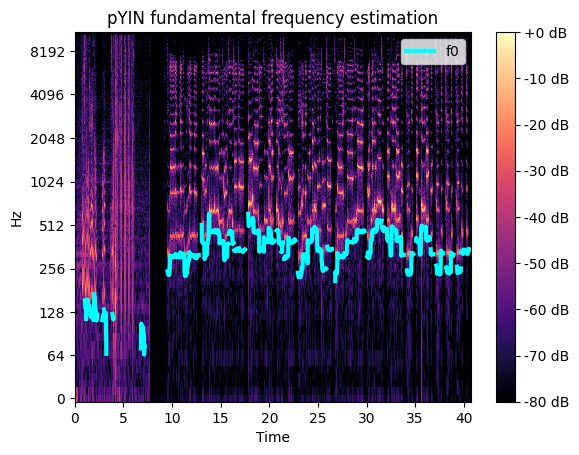

In [88]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(vt_audio)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times_list, Freq_list, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')